In [2]:
# loading all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics, cross_validation
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
from keras import optimizers
from keras import regularizers
from keras.constraints import maxnorm
from keras.layers import Dropout, BatchNormalization
from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [0]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BackOrders = pd.read_csv("/content/drive/My Drive/Colab_Folder/BackOrders.csv", na_values=["?",","])
BackOrders.head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


In [0]:
BackOrders.describe() # missing values in lead_time

Exploratory analysis to impute lead time

In [0]:
columns = ["went_on_backorder", "deck_risk", "oe_constraint", "ppap_risk", "stop_auto_buy", "rev_stop"]

for col in columns:
  plt.figure()
  sns.boxplot(x="lead_time", y=col, data=BackOrders)



Evaluating fields hich can be used to impute lead time NA values

In [0]:
print(BackOrders.groupby('stop_auto_buy', as_index=False)['lead_time'].mean())
print(BackOrders.groupby('rev_stop', as_index=False)['lead_time'].mean())
print(BackOrders.groupby('oe_constraint', as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'oe_constraint'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'rev_stop'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['rev_stop', 'oe_constraint'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'], as_index=False)['lead_time'].mean())

Imputing lead_time

In [0]:

BackOrders['lead_time'] = BackOrders.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'])['lead_time'].transform(lambda x: x.fillna(x.mean()))


Changing datatype of objects column to categories for dummification later on

In [0]:

def dtype_Convert(dtp1, col, data):
    for i in range(len(dtp1)):
        if dtp1[i] == "object":
            data[col[i]]=data[col[i]].astype('category')

In [0]:
dtp = pd.Series(BackOrders.dtypes)
dtp1 = dtp.tolist()
col = BackOrders.columns.tolist()

In [0]:
dtype_Convert(dtp1, col, BackOrders)

Outlier detection and treatment

In [0]:
cols = list(BackOrders.select_dtypes(include=['int', 'float']).columns)

for col in cols:
  plt.figure()
  sns.boxplot(x=col, y="went_on_backorder", data=BackOrders)

In [0]:
cols = list(BackOrders.select_dtypes(include=['int', 'float']).columns)

cols = [e for e in cols if e not in ("local_bo_qty", "lead_time", "sku")]


Using quantile methods for outier treatment.
Outlier treatment on new data to compare with old dataset

In [0]:
BackOrders_NoOut = pd.read_csv("/content/drive/My Drive/Colab_Folder/BackOrders.csv", na_values=["?",","])
BackOrders_NoOut['lead_time'] = BackOrders_NoOut.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'])['lead_time'].transform(lambda x: x.fillna(x.mean()))

In [0]:
def outliers_iqr(cols, df):
  for col in cols:
    quartile_1 = df[col].quantile(0.25) 
    quartile_3 = df[col].quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    median = df[col].median()
    df[col] = df[col].mask(df[col] > upper_bound, median)
    df[col] = df[col].mask(df[col] < lower_bound, median)   
  return

In [0]:
outliers_iqr(cols, BackOrders_NoOut)

Comparing summary to check effect of outlier treatment

In [0]:

print(pd.concat([pd.DataFrame(BackOrders.describe()), pd.DataFrame(BackOrders_NoOut.describe())]))

In [0]:
mapping_dictionary = {"went_on_backorder":{ "Yes": 1, "No": 0}}
BackOrders_NoOut1 = BackOrders_NoOut.replace(mapping_dictionary)

0    50296
1    11293
Name: went_on_backorder, dtype: int64


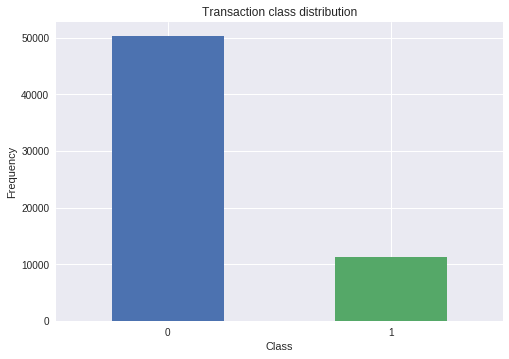

In [15]:
#Plotting the frequencies of orders which went into backorder and which did not
count_classes = pd.value_counts(BackOrders_NoOut1['went_on_backorder'], sort = True)
print(count_classes)

#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0)

#Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [16]:
print(BackOrders_NoOut1.shape)
print(BackOrders_NoOut.shape)

(61589, 23)
(61589, 23)


In [0]:
BackOrders_NoOut2 = pd.get_dummies(BackOrders_NoOut1)

In [18]:
BackOrders_NoOut2.describe(include = 'all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
count,6.158900e+04,61589.000000,61589.000000,61589.0,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,...,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000
mean,2.037188e+06,18.053646,7.679858,0.0,2.320950,4.951923,7.165874,1.457013,4.641300,9.253958,...,0.781714,0.218286,0.999805,0.000195,0.873403,0.126597,0.037117,0.962883,0.999675,0.000325
std,6.564178e+05,27.157908,6.414996,0.0,5.767793,11.631048,16.642746,2.981867,8.218458,16.263241,...,0.413086,0.413086,0.013957,0.013957,0.332524,0.332524,0.189050,0.189050,0.018018,0.018018
min,1.068628e+06,-75.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.498574e+06,3.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.898033e+06,10.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,2.314826e+06,18.000000,8.000000,0.0,0.000000,2.000000,4.000000,1.000000,4.000000,9.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,3.284895e+06,138.000000,52.000000,0.0,30.000000,62.000000,90.000000,15.000000,42.000000,85.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
BackOrders_NoOut2.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'went_on_backorder', 'potential_issue_No',
       'potential_issue_Yes', 'deck_risk_No', 'deck_risk_Yes',
       'oe_constraint_No', 'oe_constraint_Yes', 'ppap_risk_No',
       'ppap_risk_Yes', 'stop_auto_buy_No', 'stop_auto_buy_Yes', 'rev_stop_No',
       'rev_stop_Yes'],
      dtype='object')

Creating training and test set




In [0]:
# Divide in to train and test
y=BackOrders_NoOut2["went_on_backorder"]
X=BackOrders_NoOut2.drop('went_on_backorder', axis=1)

#from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [0]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [24]:
input_dim = X_train.shape[1]
print(input_dim)
# encoding_dim = 15

28


In [0]:
model = Sequential()
model.add(Dense(1,input_dim=input_dim, activation='sigmoid', kernel_initializer='random_normal',kernel_regularizer="l1"))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

In [0]:
scores = model.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [0]:
y_pred_class = model.predict_classes(X_test)

In [0]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

In [0]:
# print the confusion matrix
confusion_matrix_test=metrics.confusion_matrix(y_test, y_pred_class)

In [0]:
confusion_matrix_test

In [0]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(4,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l1"))
model_MLP.add(Dense(1,activation='sigmoid'))
model_MLP.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(14,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l1"))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
model_MLP.add(BatchNormalization())
model_MLP.add(Dense(1,activation='sigmoid'))
model_MLP.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(14,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l2"))
# model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
# model_MLP.add(BatchNormalization())
model_MLP.add(Dense(1,activation='sigmoid'))


In [0]:
model_MLP.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
model_MLP.fit(X_train, y_train, epochs=50, batch_size=32)

In [0]:
lr_values = np.logspace(-4, -1, num=5)
lr_values

In [0]:
lr_values = [0.003]

In [0]:
nb_epoch = 20
batch_size = 32

def compile_fit(model, X, Y, lr_value):
    
    adam = optimizers.Adam(lr=lr_value)
    
    model_MLP.compile(optimizer=adam, 
                    loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model_MLP.fit(X, Y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)    
    return history
  
hist = []
training_loss = []
val_loss = []


for lr_value in lr_values:
    print(lr_value)
    history = (compile_fit(model_MLP, X_train, y_train, lr_value))
  
    hist.append(history)
  
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
  

In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(nb_epoch))

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [0]:
scores = model_MLP.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model_MLP.metrics_names[1], scores[1]*100))

In [0]:
y_pred_class_MLP = model_MLP.predict_classes(X_test)

In [0]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred_class_MLP)

In [0]:
# print the confusion matrix
confusion_matrix_test_mlp=metrics.confusion_matrix(y_test,y_pred_class_MLP)

In [0]:
Accuracy_Test=(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[1,1])/(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[0,1]+confusion_matrix_test_mlp[1,0]+confusion_matrix_test_mlp[1,1])
TNR_Test= confusion_matrix_test_mlp[0,0]/(confusion_matrix_test_mlp[0,0] +confusion_matrix_test_mlp[0,1])
TPR_Test= confusion_matrix_test_mlp[1,1]/(confusion_matrix_test_mlp[1,0] +confusion_matrix_test_mlp[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

using grid search approach to find the best model

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [0]:
def create_model(activation,  neurons, learn_rate, kernel_regularizer):
    
#     # create model
#     model = Sequential()
#     model.add(Dense(4, input_dim=15, kernel_initializer=init_mode, activation='tanh'))
#     model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    
#     # Compile model
#     sgd=optimizers.SGD(0.001)
#     model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print("learning rate ", learn_rate)
    print("activation", activation)
    print("neurons in 1st layer", neurons)
    print("kernel regularizer", kernel_regularizer)
    # create model
    adam = optimizers.Adam(lr=learn_rate)
    
    
    model_MLP = Sequential()
    model_MLP.add(Dense(neurons,input_dim=input_dim, activation=activation,kernel_regularizer=kernel_regularizer))
    model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
    model_MLP.add(Dense(1,activation='sigmoid'))
    
    # compile model
    model_MLP.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model_MLP


In [0]:
model = KerasClassifier(build_fn=create_model, epochs=20, verbose=1)

In [29]:
# init_mode = ['uniform', 'lecun_uniform']
kernel_regularizer = ['l1', 'l2']
activation = ['softmax', 'softplus', 'relu', 'tanh', 'sigmoid']
# batch_size = [32, 64]
learn_rate = [0.003, 0.006]
# epochs=[20,30]
neurons = [10, 14]
# batch_size=[32]
param_grid = dict(
#     init_mode=init_mode,
                  kernel_regularizer = kernel_regularizer, 
#                   batch_size=batch_size,
                  activation = activation, 
                  learn_rate = learn_rate, neurons=neurons
                 )
param_grid

{'activation': ['softmax', 'softplus', 'relu', 'tanh', 'sigmoid'],
 'kernel_regularizer': ['l1', 'l2'],
 'learn_rate': [0.003, 0.006],
 'neurons': [10, 14]}

In [30]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='f1')
grid_result = grid.fit(X_train, y_train)

learning rate  0.003
activation softmax
neurons in 1st layer 10
kernel regularizer l1
Epoch 1/20
24635/24635 [==============================] - 5s 220us/step - loss: 0.5447 - acc: 0.8029
Epoch 2/20
24635/24635 [==============================] - 4s 181us/step - loss: 0.4833 - acc: 0.8129
Epoch 3/20
24635/24635 [==============================] - 4s 181us/step - loss: 0.4834 - acc: 0.8129
Epoch 4/20
24635/24635 [==============================] - 4s 181us/step - loss: 0.4835 - acc: 0.8129
Epoch 5/20
24635/24635 [==============================] - 4s 182us/step - loss: 0.4834 - acc: 0.8129
Epoch 6/20
24635/24635 [==============================] - 4s 182us/step - loss: 0.4833 - acc: 0.8129
Epoch 7/20
24635/24635 [==============================] - 5s 184us/step - loss: 0.4835 - acc: 0.8129
Epoch 8/20
24635/24635 [==============================] - 4s 181us/step - loss: 0.4834 - acc: 0.8129
Epoch 9/20
24635/24635 [==============================] - 4s 181us/step - loss: 0.4834 - acc: 0.8129
Epoch

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


24635/24635 [==============================] - 1s 36us/step
learning rate  0.006
activation softmax
neurons in 1st layer 14
kernel regularizer l2
Epoch 1/20
24636/24636 [==============================] - 5s 218us/step - loss: 0.4057 - acc: 0.8322
Epoch 2/20
24636/24636 [==============================] - 5s 186us/step - loss: 0.3522 - acc: 0.8588
Epoch 3/20
24636/24636 [==============================] - 5s 187us/step - loss: 0.3431 - acc: 0.8645
Epoch 4/20
24636/24636 [==============================] - 5s 186us/step - loss: 0.3380 - acc: 0.8680
Epoch 5/20
24636/24636 [==============================] - 5s 185us/step - loss: 0.3350 - acc: 0.8709
Epoch 6/20
24636/24636 [==============================] - 5s 185us/step - loss: 0.3312 - acc: 0.8706
Epoch 7/20
24636/24636 [==============================] - 5s 184us/step - loss: 0.3295 - acc: 0.8734
Epoch 8/20
24636/24636 [==============================] - 5s 185us/step - loss: 0.3261 - acc: 0.8733
Epoch 9/20
24636/24636 [======================

In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.666964 using {'activation': 'relu', 'kernel_regularizer': 'l2', 'learn_rate': 0.003, 'neurons': 10}
0.505569 (0.045240) with: {'activation': 'softmax', 'kernel_regularizer': 'l1', 'learn_rate': 0.003, 'neurons': 10}
0.545521 (0.038753) with: {'activation': 'softmax', 'kernel_regularizer': 'l1', 'learn_rate': 0.003, 'neurons': 14}
0.547626 (0.079408) with: {'activation': 'softmax', 'kernel_regularizer': 'l1', 'learn_rate': 0.006, 'neurons': 10}
0.564513 (0.014979) with: {'activation': 'softmax', 'kernel_regularizer': 'l1', 'learn_rate': 0.006, 'neurons': 14}
0.617526 (0.006506) with: {'activation': 'softmax', 'kernel_regularizer': 'l2', 'learn_rate': 0.003, 'neurons': 10}
0.590407 (0.033024) with: {'activation': 'softmax', 'kernel_regularizer': 'l2', 'learn_rate': 0.003, 'neurons': 14}
0.617365 (0.010372) with: {'activation': 'softmax', 'kernel_regularizer': 'l2', 'learn_rate': 0.006, 'neurons': 10}
0.296956 (0.296962) with: {'activation': 'softmax', 'kernel_regularizer': 'l2', 

In [0]:
def create_model(init_mode):
    
#     # create model
#     model = Sequential()
#     model.add(Dense(4, input_dim=15, kernel_initializer=init_mode, activation='tanh'))
#     model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    
#     # Compile model
#     sgd=optimizers.SGD(0.001)
#     model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print("init_mode", init_mode)
  
    # create model
    adam = optimizers.Adam(lr=0.003)
    
    
    model_MLP = Sequential()
    model_MLP.add(Dense(10,input_dim=input_dim, kernel_initializer=init_mode, activation='relu',kernel_regularizer='l2'))
    model_MLP.add(Dense(4, activation='relu', kernel_initializer=init_mode, kernel_constraint=maxnorm(3)))
    model_MLP.add(Dense(1,activation='sigmoid'))
    
    # compile model
    model_MLP.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model_MLP


In [0]:
model = KerasClassifier(build_fn=create_model, verbose=1)

In [37]:
init_mode = ['uniform', 'lecun_uniform']
# kernel_regularizer = ['l1', 'l2']
# activation = ['softmax', 'softplus', 'relu', 'tanh', 'sigmoid']
batch_size = [32, 64]
# learn_rate = [0.003, 0.006]
epochs=[20,30]
# neurons = [10, 14]
# batch_size=[32]
param_grid = dict(
    init_mode=init_mode,
#                   kernel_regularizer = kernel_regularizer, 
                  batch_size=batch_size,
#                   activation = activation, 
                  epochs = epochs
#                   learn_rate = learn_rate, neurons=neurons
                 )
param_grid

{'batch_size': [32, 64],
 'epochs': [20, 30],
 'init_mode': ['uniform', 'lecun_uniform']}

In [38]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='f1')
grid_result = grid.fit(X_train, y_train)

init_mode uniform
Epoch 1/20
24635/24635 [==============================] - 12s 469us/step - loss: 0.3922 - acc: 0.8287
Epoch 2/20
24635/24635 [==============================] - 6s 225us/step - loss: 0.3584 - acc: 0.8536
Epoch 3/20
24635/24635 [==============================] - 6s 224us/step - loss: 0.3515 - acc: 0.8569
Epoch 4/20
24635/24635 [==============================] - 6s 224us/step - loss: 0.3489 - acc: 0.8622
Epoch 5/20
24635/24635 [==============================] - 6s 225us/step - loss: 0.3482 - acc: 0.8624
Epoch 6/20
24635/24635 [==============================] - 5s 223us/step - loss: 0.3452 - acc: 0.8631
Epoch 7/20
24635/24635 [==============================] - 6s 225us/step - loss: 0.3430 - acc: 0.8622
Epoch 8/20
24635/24635 [==============================] - 6s 226us/step - loss: 0.3435 - acc: 0.8634
Epoch 9/20
24635/24635 [==============================] - 5s 223us/step - loss: 0.3423 - acc: 0.8636
Epoch 10/20
24635/24635 [==============================] - 6s 224us/step

In [39]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.681447 using {'batch_size': 32, 'epochs': 20, 'init_mode': 'lecun_uniform'}
0.603531 (0.025665) with: {'batch_size': 32, 'epochs': 20, 'init_mode': 'uniform'}
0.681447 (0.011319) with: {'batch_size': 32, 'epochs': 20, 'init_mode': 'lecun_uniform'}
0.579996 (0.050080) with: {'batch_size': 32, 'epochs': 30, 'init_mode': 'uniform'}
0.659840 (0.000426) with: {'batch_size': 32, 'epochs': 30, 'init_mode': 'lecun_uniform'}
0.674095 (0.004834) with: {'batch_size': 64, 'epochs': 20, 'init_mode': 'uniform'}
0.663128 (0.006818) with: {'batch_size': 64, 'epochs': 20, 'init_mode': 'lecun_uniform'}
0.655220 (0.006957) with: {'batch_size': 64, 'epochs': 30, 'init_mode': 'uniform'}
0.660640 (0.001376) with: {'batch_size': 64, 'epochs': 30, 'init_mode': 'lecun_uniform'}


Running the final model after getting best parameters

In [0]:
adam = optimizers.Adam(lr=0.003)
    
    
model_MLP = Sequential()
model_MLP.add(Dense(10,input_dim=input_dim, kernel_initializer='lecun_uniform', activation='relu',kernel_regularizer='l2'))
model_MLP.add(Dense(4, activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3)))
model_MLP.add(Dense(1,activation='sigmoid'))
    
# compile model
model_MLP.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [41]:
model_MLP.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
49271/49271 [==============================] - 19s 388us/step - loss: 0.3578 - acc: 0.8555
Epoch 2/20
49271/49271 [==============================] - 12s 235us/step - loss: 0.3152 - acc: 0.8779
Epoch 3/20
49271/49271 [==============================] - 12s 235us/step - loss: 0.3079 - acc: 0.8801
Epoch 4/20
49271/49271 [==============================] - 12s 235us/step - loss: 0.3018 - acc: 0.8830
Epoch 5/20
49271/49271 [==============================] - 12s 236us/step - loss: 0.3009 - acc: 0.8838
Epoch 6/20
49271/49271 [==============================] - 12s 236us/step - loss: 0.2991 - acc: 0.8830
Epoch 7/20
49271/49271 [==============================] - 12s 235us/step - loss: 0.2983 - acc: 0.8841
Epoch 8/20
49271/49271 [==============================] - 12s 236us/step - loss: 0.2984 - acc: 0.8839
Epoch 9/20
49271/49271 [==============================] - 12s 236us/step - loss: 0.2949 - acc: 0.8852
Epoch 10/20
49271/49271 [==============================] - 12s 236us/step - loss: 

In [42]:
scores = model_MLP.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model_MLP.metrics_names[1], scores[1]*100))

49271/49271 [==============================] - 9s 176us/step
acc: 88.80%


In [0]:
y_pred_class_MLP = model_MLP.predict_classes(X_test)

In [44]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred_class_MLP)

0.8862640038967364

In [0]:
# print the confusion matrix
confusion_matrix_test_mlp=metrics.confusion_matrix(y_test,y_pred_class_MLP)

In [46]:
Accuracy_Test=(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[1,1])/(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[0,1]+confusion_matrix_test_mlp[1,0]+confusion_matrix_test_mlp[1,1])
TNR_Test= confusion_matrix_test_mlp[0,0]/(confusion_matrix_test_mlp[0,0] +confusion_matrix_test_mlp[0,1])
TPR_Test= confusion_matrix_test_mlp[1,1]/(confusion_matrix_test_mlp[1,0] +confusion_matrix_test_mlp[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9391597304795878
Test TPR:  0.6464510332434861
Test Accuracy:  0.8862640038967364
